###Install Library

In [1]:
!pip install -q torch
!pip install -q tf
!pip install -q gdown
!pip install -q "transformers[torch]" accelerate -U
!pip install -q -U accelerate
!pip install -q datasets
!pip install -q gensim
!pip install -q tensorflow
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.0 MB/s eta 0:00:00


### Import Library

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from collections import Counter
import tensorflow as tf
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, AutoConfig, TrainingArguments, EarlyStoppingCallback
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Flatten, concatenate, BatchNormalization,LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from evaluate import load as load_metric
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import BorderlineSMOTE,KMeansSMOTE,SVMSMOTE

###Read Dataset and load Word2Vec

In [3]:
df = pd.read_csv("/content/pilpres_train_balanced_clean.csv")

In [4]:
df_test1 = pd.read_csv("/content/pilpres_test_clean.csv")

In [5]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
gc.collect()
print(gensim.__version__)
# Load Pretrained Word Embeddings (Word2Vec)
# !gdown --id 1QYj5FruufaPq2mZgC6lZlq2Uw2E004Og
# !gdown --id 1F9QsHO7FPIPq3nL_I0zCkZFvq3OVcJrB
# !gdown --id 1VUjxpH10baOw439V-YAAVVbtyI8iLgG5

4.4.0


In [6]:
import os
import gdown
import zipfile

'''https://drive.google.com/file/d/1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3/view?usp=sharing'''

file_id = '1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3'

url = f'https://drive.google.com/uc?id={file_id}'
output_zip = 'model_w2v.zip'

if not os.path.exists('idwiki_word2vec_768_new_lower.model'):
    print("Downloading Model...")
    gdown.download(url, output_zip, quiet=False)

    print("Extracting File...")
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Done.")
else:
    print("Model Available")


Downloading...
From (original): https://drive.google.com/uc?id=1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3
From (redirected): https://drive.google.com/uc?id=1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3&confirm=t&uuid=3d377748-f94f-42f9-bcfb-c3f1de1c32cb
To: /content/model_w2v.zip
100%|██████████| 2.56G/2.56G [00:23<00:00, 110MB/s] 


Extracting File...
Done.


In [7]:
word_embeddings = Word2Vec.load('/content/idwiki_word2vec_768_new_lower.model')

###Split Dataset

In [8]:
x_train = df['Text']
y_train = df['Label']

In [9]:
x_test1 = df_test1['Text']
y_test1 = np.array(df_test1['Label'])

###Define Loss Function, Tokenization, Word Embeddings and Oversampling

In [10]:
# Define the margin loss function
def margin_loss(y_true, y_pred):
    margin = K.constant(0.1)
    y_true_float = K.cast(y_true, dtype='float32')  # Convert y_true to float32
    squared_difference_pos = K.square(K.maximum(0.9 - y_pred, 0))
    squared_difference_neg = K.square(K.maximum(y_pred - 0.1, 0))
    loss_pos = K.mean(y_true_float * squared_difference_pos)
    loss_neg = K.mean((1 - y_true_float) * squared_difference_neg)
    total_loss = loss_pos + lambda_val * loss_neg
    return total_loss

In [11]:
# Define the model architectures
#embedding_dim = 300
#max_sequence_length = 100
lambda_val = 0.7  # Lambda value for margin loss
#num_words = 100000
max_sequence_length = 100 # Moving the definition of max_sequence_length here

In [12]:
# Create word index
word_index = {word: index + 1 for index, word in enumerate(word_embeddings.wv.index_to_key)}

# Create embedding matrix
embedding_dim = word_embeddings.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word_embeddings.wv:
        embedding_vector = word_embeddings.wv[word]
        embedding_matrix[i] = embedding_vector


In [13]:
# Tokenization
tokenizer = Tokenizer(num_words=len(word_index) + 1, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train.astype(str))

# Convert text to sequences and pad
x_train_sequences = tokenizer.texts_to_sequences(x_train.astype(str))
# Convert all values in x_test1 to string before tokenization
x_test_sequences1 = tokenizer.texts_to_sequences(x_test1.astype(str))

# Determine max sequence length based on your data
max_sequence_length = max(max(len(seq) for seq in x_train_sequences), max(len(seq) for seq in x_test_sequences1))

x_train_padded = pad_sequences(x_train_sequences, maxlen=max_sequence_length, padding='post')
x_test_padded1 = pad_sequences(x_test_sequences1, maxlen=max_sequence_length, padding='post')

In [14]:
x_train_flat = x_train_padded.reshape(x_train_padded.shape[0], -1)

####Oversampling with BorderlineSMOTE

In [15]:
borderline_smote = BorderlineSMOTE(random_state=42)
x_train_resampled_flat_borderline, y_train_resampled_borderline = borderline_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_borderline = x_train_resampled_flat_borderline.reshape(x_train_resampled_flat_borderline.shape[0], max_sequence_length)

####Oversampling with KMeansSMOTE

In [16]:
kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.2)
x_train_resampled_flat_kmeans, y_train_resampled_kmeans = kmeans_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_kmeans = x_train_resampled_flat_kmeans.reshape(x_train_resampled_flat_kmeans.shape[0], max_sequence_length)

####Oversampling with SVMSMOTE

In [17]:
svm_smote = SVMSMOTE(random_state=42)
x_train_resampled_flat_svm, y_train_resampled_svm = svm_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_svm = x_train_resampled_flat_svm.reshape(x_train_resampled_flat_svm.shape[0], max_sequence_length)

In [18]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


##LSTM Model

In [20]:
# Define the architecture of the static model with he_normal initialization
lstm_input = Input(shape=(max_sequence_length,))
lstm_embedding = Embedding(len(word_index) + 1, embedding_dim, input_length=max_sequence_length, trainable=False)(lstm_input)  # Removed weights parameter

# LSTM Layers
static_lstm_output = LSTM(128, kernel_initializer=he_normal())(lstm_embedding)  # Use he_normal initialization
static_lstm_output = Dropout(0.5)(static_lstm_output)
batch_norm_layer = BatchNormalization()(static_lstm_output)

# Fully Connected Layers
static_dense_output = Dense(128, activation='relu', kernel_initializer=he_normal())(batch_norm_layer)  # Use he_normal initialization
static_dense_output = Dropout(0.5)(static_dense_output)
output = Dense(1, activation='sigmoid')(static_dense_output)

# Create the static model
lstm_model = Model(inputs=lstm_input, outputs=output)
lstm_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


###LSTM BorderlineSMOTE Train and Test

In [21]:
# Train the LSTM model
epochs_lstm = 10
history_lstm_borderline = lstm_model.fit(
    x_train_resampled_borderline,
    y_train_resampled_borderline,
    batch_size=32,
    epochs=epochs_lstm,
    validation_split=0.1,
)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5008 - loss: 0.1973 - val_accuracy: 1.0000 - val_loss: 0.1171
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4962 - loss: 0.1642 - val_accuracy: 1.0000 - val_loss: 0.1413
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4878 - loss: 0.1485 - val_accuracy: 1.0000 - val_loss: 0.1553
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4927 - loss: 0.1435 - val_accuracy: 1.0000 - val_loss: 0.1577
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4875 - loss: 0.1387 - val_accuracy: 1.0000 - val_loss: 0.1382
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4871 - loss: 0.1363 - val_accuracy: 1.0000 - val_loss: 0.1384
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4783 - loss: 0.1358 - val_accuracy: 1.0000 - val_loss: 0.1479
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5092 - loss: 0.1311 - val_accuracy:

####Cross-Validation Train

In [22]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []

In [23]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_borderline)
y_train_np = np.array(y_train_resampled_borderline)

In [24]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_lstm = []
val_accuracies_lstm = []
train_losses_lstm = []
val_losses_lstm = []
classification_reports_lstm = []

# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    lstm_model = Model(inputs=lstm_input, outputs=output)

    lstm_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = lstm_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=32,
        epochs=epochs_lstm,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_lstm, train_accuracy_lstm = lstm_model.evaluate(x_train_fold, y_train_fold)
    val_loss_lstm, val_accuracy_lstm = lstm_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_lstm}, Training Accuracy: {train_accuracy_lstm}")
    print(f"Fold {fold} - Validation Loss: {val_loss_lstm}, Validation Accuracy: {val_accuracy_lstm}")

    # Store the results for this fold
    train_accuracies_lstm.append(train_accuracy_lstm)
    val_accuracies_lstm.append(val_accuracy_lstm)
    train_losses_lstm.append(train_loss_lstm)
    val_losses_lstm.append(val_loss_lstm)

    # Evaluate the model
    y_pred = (lstm_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_lstm.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)

Training fold 1/10
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7542 - loss: 0.0948 - val_accuracy: 0.8201 - val_loss: 0.0667
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8353 - loss: 0.0656 - val_accuracy: 0.8424 - val_loss: 0.0633
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8419 - loss: 0.0628 - val_accuracy: 0.7978 - val_loss: 0.0718
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8469 - loss: 0.0598 - val_accuracy: 0.7420 - val_loss: 0.0826
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7527 - loss: 0.0827 - val_accuracy: 0.7675 - val_loss: 0.0810
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7900 - loss: 0.0643
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7989 - loss: 0.0641
Fold 1 - Training Loss: 0.058665186166763306, Training Accuracy: 0.8524619340896606
Fold 1 - Validation Loss: 0.06325183063745499, Validation Accuracy: 0.8423566818237305
20/20 ━━━━━━━━━━━━━━

In [25]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_lstm) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_lstm]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_lstm) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_lstm) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_lstm]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_lstm) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.9429188132286072, Std Training Accuracy: 0.03797302551713569
Mean Training Loss: 0.02547377413138747, Std Training Loss: 0.0142557967854267
Mean Validation Accuracy: 0.9392997205257416, Std Validation Accuracy: 0.041821429484396704
Mean Validation Loss: 0.027295084577053784, Std Validation Loss: 0.01566314300688925


In [26]:
avg_report_lstm = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['0']['support'] for r in classification_reports_lstm])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['1']['support'] for r in classification_reports_lstm])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_lstm)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(0.9711699933500182), 'recall': np.float64(0.905328012555459), 'f1-score': np.float64(0.9354436374922142), 'support': np.float64(3137.0)}, 'Class 1': {'precision': np.float64(0.9162373816778964), 'recall': np.float64(0.97299636617673), 'f1-score': np.float64(0.9424972097042567), 'support': np.float64(3137.0)}}


In [27]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_LSTM_borderline.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_lstm):
    # Training metrics for the current epoch
    train_loss = history_lstm_borderline.history['loss'][epoch]
    train_accuracy = history_lstm_borderline.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_lstm_borderline.history['val_loss'][epoch]
    val_accuracy = history_lstm_borderline.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)


####Testing

In [28]:
# Evaluate the static model
lstm_evaluation1 = lstm_model.evaluate(x_test_padded1, y_test1, batch_size=32)
lstm_accuracy1 = lstm_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", lstm_accuracy1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9242 - loss: 0.0438 
Static Model Evaluation Results:
Accuracy: 0.9192708134651184


In [29]:
y_test_pred1 = (lstm_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       349
           1       0.57      0.46      0.51        35

    accuracy                           0.92       384
   macro avg       0.76      0.71      0.73       384
weighted avg       0.91      0.92      0.92       384



In [30]:
torch.cuda.empty_cache()

###LSTM KMeansSMOTE Train and Test

In [31]:
lstm_model = Model(inputs=lstm_input, outputs=output)
lstm_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

In [32]:
# Train the LSTM model
epochs_lstm = 10
history_lstm_kmeans = lstm_model.fit(
    x_train_resampled_kmeans,
    y_train_resampled_kmeans,
    batch_size=32,
    epochs=epochs_lstm,
    validation_split=0.1,
)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9804 - loss: 0.0109 - val_accuracy: 0.9777 - val_loss: 0.0160
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9827 - loss: 0.0098 - val_accuracy: 0.9777 - val_loss: 0.0163
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9781 - loss: 0.0127 - val_accuracy: 0.9745 - val_loss: 0.0196
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9734 - loss: 0.0165 - val_accuracy: 0.9554 - val_loss: 0.0239
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9843 - loss: 0.0093 - val_accuracy: 0.9586 - val_loss: 0.0276
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9857 - loss: 0.0088 - val_accuracy: 0.9777 - val_loss: 0.0158
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9905 - loss: 0.0058 - val_accuracy: 0.9777 - val_loss: 0.0160
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9918 - loss: 0.0052 - val_accuracy: 0

In [33]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []

In [34]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_kmeans)
y_train_np = np.array(y_train_resampled_kmeans)

In [35]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_lstm = []
val_accuracies_lstm = []
train_losses_lstm = []
val_losses_lstm = []
classification_reports_lstm = []

# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    lstm_model = Model(inputs=lstm_input, outputs=output)

    lstm_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = lstm_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=32,
        epochs=epochs_lstm,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_lstm, train_accuracy_lstm = lstm_model.evaluate(x_train_fold, y_train_fold)
    val_loss_lstm, val_accuracy_lstm = lstm_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_lstm}, Training Accuracy: {train_accuracy_lstm}")
    print(f"Fold {fold} - Validation Loss: {val_loss_lstm}, Validation Accuracy: {val_accuracy_lstm}")

    # Store the results for this fold
    train_accuracies_lstm.append(train_accuracy_lstm)
    val_accuracies_lstm.append(val_accuracy_lstm)
    train_losses_lstm.append(train_loss_lstm)
    val_losses_lstm.append(val_loss_lstm)

    # Evaluate the model
    y_pred = (lstm_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_lstm.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)

Training fold 1/10
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9871 - loss: 0.0078 - val_accuracy: 0.9904 - val_loss: 0.0061
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9894 - loss: 0.0069 - val_accuracy: 0.9968 - val_loss: 0.0017
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9860 - loss: 0.0074 - val_accuracy: 0.9889 - val_loss: 0.0073
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9856 - loss: 0.0082 - val_accuracy: 0.9857 - val_loss: 0.0078
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9534 - loss: 0.0222 - val_accuracy: 0.9538 - val_loss: 0.0239
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9942 - loss: 0.0029
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 8.8041e-04
Fold 1 - Training Loss: 0.0028478458989411592, Training Accuracy: 0.9948636293411255
Fold 1 - Validation Loss: 0.001698030042462051, Validation Accuracy: 0.9968152642250061
20/20 ━━━━━━━━

In [36]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_lstm) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_lstm]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_lstm) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_lstm) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_lstm]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_lstm) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.9953421175479888, Std Training Accuracy: 0.0038416089591497703
Mean Training Loss: 0.0026909545063972472, Std Training Loss: 0.0022130209227317786
Mean Validation Accuracy: 0.9961763083934784, Std Validation Accuracy: 0.0032006959455474324
Mean Validation Loss: 0.0021321775391697885, Std Validation Loss: 0.0018335024337301242


In [37]:
avg_report_lstm = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['0']['support'] for r in classification_reports_lstm])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['1']['support'] for r in classification_reports_lstm])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_lstm)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(0.9971515035936758), 'recall': np.float64(0.9952397452381587), 'f1-score': np.float64(0.9961889841912775), 'support': np.float64(3137.0)}, 'Class 1': {'precision': np.float64(0.9952153799678063), 'recall': np.float64(0.9971147645209741), 'f1-score': np.float64(0.996158554289652), 'support': np.float64(3137.0)}}


In [38]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_LSTM_kmeans.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_lstm):
    # Training metrics for the current epoch
    train_loss = history_lstm_kmeans.history['loss'][epoch]
    train_accuracy = history_lstm_kmeans.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_lstm_kmeans.history['val_loss'][epoch]
    val_accuracy = history_lstm_kmeans.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)


####Testing

In [39]:
# Evaluate the static model
lstm_evaluation1 = lstm_model.evaluate(x_test_padded1, y_test1, batch_size=32)
lstm_accuracy1 = lstm_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", lstm_accuracy1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9161 - loss: 0.0564 
Static Model Evaluation Results:
Accuracy: 0.9192708134651184


In [40]:
y_test_pred1 = (lstm_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       349
           1       0.58      0.43      0.49        35

    accuracy                           0.92       384
   macro avg       0.76      0.70      0.72       384
weighted avg       0.91      0.92      0.91       384



In [41]:
torch.cuda.empty_cache()

###LSTM SVMSMOTE Train and Test

In [42]:
lstm_model = Model(inputs=lstm_input, outputs=output)
lstm_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

In [43]:
# Train the LSTM model
epochs_lstm = 10
history_lstm_svm = lstm_model.fit(
    x_train_resampled_svm,
    y_train_resampled_svm,
    batch_size=32,
    epochs=epochs_lstm,
    validation_split=0.1,
)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9946 - loss: 0.0032 - val_accuracy: 0.9857 - val_loss: 0.0087
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9929 - loss: 0.0040 - val_accuracy: 0.9857 - val_loss: 0.0086
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9944 - loss: 0.0033 - val_accuracy: 0.9920 - val_loss: 0.0058
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9934 - loss: 0.0038 - val_accuracy: 0.9984 - val_loss: 0.0015
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9961 - loss: 0.0021 - val_accuracy: 0.9984 - val_loss: 0.0013
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9969 - loss: 0.0016 - val_accuracy: 0.9092 - val_loss: 0.0664
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9872 - loss: 0.0085 - val_accuracy: 0.9889 - val_loss: 0.0079
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9928 - loss: 0.0045 - val_accuracy: 0

####Cross-Validation Train

In [44]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []

In [45]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_svm)
y_train_np = np.array(y_train_resampled_svm)

In [46]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_lstm = []
val_accuracies_lstm = []
train_losses_lstm = []
val_losses_lstm = []
classification_reports_lstm = []

# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    lstm_model = Model(inputs=lstm_input, outputs=output)

    lstm_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = lstm_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=32,
        epochs=epochs_lstm,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_lstm, train_accuracy_lstm = lstm_model.evaluate(x_train_fold, y_train_fold)
    val_loss_lstm, val_accuracy_lstm = lstm_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_lstm}, Training Accuracy: {train_accuracy_lstm}")
    print(f"Fold {fold} - Validation Loss: {val_loss_lstm}, Validation Accuracy: {val_accuracy_lstm}")

    # Store the results for this fold
    train_accuracies_lstm.append(train_accuracy_lstm)
    val_accuracies_lstm.append(val_accuracy_lstm)
    train_losses_lstm.append(train_loss_lstm)
    val_losses_lstm.append(val_loss_lstm)

    # Evaluate the model
    y_pred = (lstm_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_lstm.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)

Training fold 1/10
Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9954 - loss: 0.0025 - val_accuracy: 0.9920 - val_loss: 0.0024
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9940 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9970 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9985 - loss: 8.6484e-04 - val_accuracy: 0.9968 - val_loss: 0.0026
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9968 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9971 - loss: 0.0014
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Fold 1 - Training Loss: 0.0009153978899121284, Training Accuracy: 0.9978746175765991
Fold 1 - Validation Loss: 0.0, Validation Accuracy: 1.0
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [47]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_lstm) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_lstm]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_lstm) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_lstm) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_lstm]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_lstm) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.9984592616558075, Std Training Accuracy: 0.000849453621701659
Mean Training Loss: 0.0009078219416551292, Std Training Loss: 0.0005955779990276804
Mean Validation Accuracy: 0.9988835692405701, Std Validation Accuracy: 0.0018938401077089346
Mean Validation Loss: 0.0006527546378492843, Std Validation Loss: 0.0010221526747710137


In [48]:
avg_report_lstm = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['0']['support'] for r in classification_reports_lstm])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['1']['support'] for r in classification_reports_lstm])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_lstm)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(0.9996774193548387), 'recall': np.float64(0.9980048405983306), 'f1-score': np.float64(0.9988379554677834), 'support': np.float64(3137.0)}, 'Class 1': {'precision': np.float64(0.9981690112090045), 'recall': np.float64(0.9996835443037975), 'f1-score': np.float64(0.9989238065977071), 'support': np.float64(3137.0)}}


In [49]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_LSTM_svm.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_lstm):
    # Training metrics for the current epoch
    train_loss = history_lstm_svm.history['loss'][epoch]
    train_accuracy = history_lstm_svm.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_lstm_svm.history['val_loss'][epoch]
    val_accuracy = history_lstm_svm.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)


####Testing

In [50]:
# Evaluate the static model
lstm_evaluation1 = lstm_model.evaluate(x_test_padded1, y_test1, batch_size=32)
lstm_accuracy1 = lstm_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", lstm_accuracy1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9286 - loss: 0.0522 
Static Model Evaluation Results:
Accuracy: 0.9322916865348816


In [51]:
y_test_pred1 = (lstm_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       349
           1       0.68      0.49      0.57        35

    accuracy                           0.93       384
   macro avg       0.81      0.73      0.76       384
weighted avg       0.93      0.93      0.93       384



In [52]:
torch.cuda.empty_cache()

##Evaluation

In [53]:
torch.cuda.empty_cache()

In [54]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

###LSTM

####BorderlineSMOTE

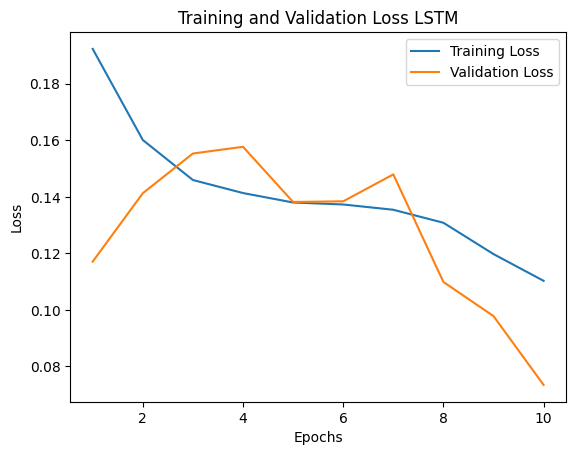

In [55]:
import matplotlib.pyplot as plt
train_loss_lstm = history_lstm_borderline.history['loss']
val_loss_lstm = history_lstm_borderline.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_lstm) + 1), train_loss_lstm, label='Training Loss')
plt.plot(range(1, len(val_loss_lstm) + 1), val_loss_lstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss LSTM')
plt.legend()
plt.show()

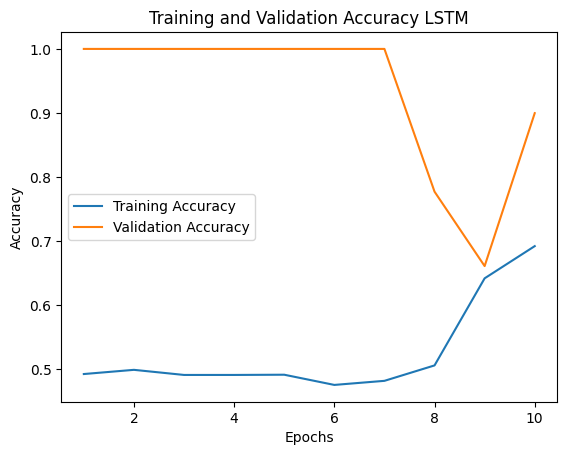

In [56]:
import matplotlib.pyplot as plt
accuracy_lstm = history_lstm_borderline.history['accuracy']
val_accuracy_lstm = history_lstm_borderline.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_lstm) + 1), accuracy_lstm, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_lstm) + 1), val_accuracy_lstm, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy LSTM')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


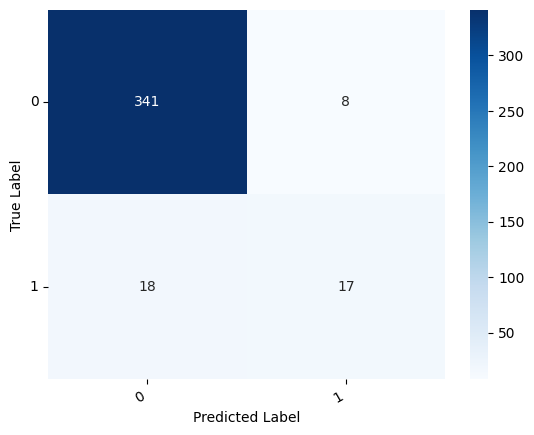

In [57]:
predictions_lstm_1 = lstm_model.predict(x_test_padded1)
predicted_labels_lstm_1 = (predictions_lstm_1 > 0.5).astype(int)
cm_lstm_1 = confusion_matrix(y_test1,predicted_labels_lstm_1)
show_confusion_matrix(cm_lstm_1)

####KMeansSMOTE

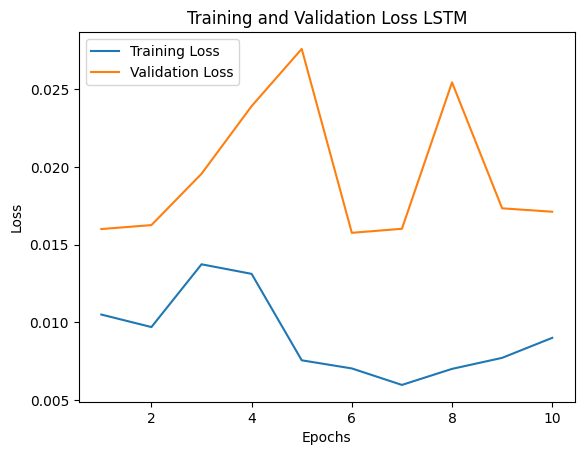

In [58]:
import matplotlib.pyplot as plt
train_loss_lstm = history_lstm_kmeans.history['loss']
val_loss_lstm = history_lstm_kmeans.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_lstm) + 1), train_loss_lstm, label='Training Loss')
plt.plot(range(1, len(val_loss_lstm) + 1), val_loss_lstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss LSTM')
plt.legend()
plt.show()

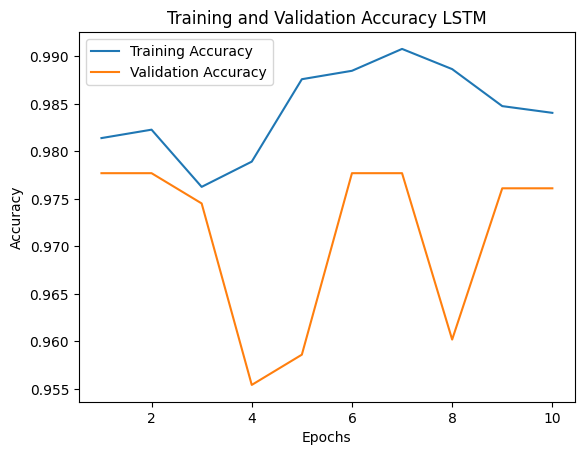

In [59]:
import matplotlib.pyplot as plt
accuracy_lstm = history_lstm_kmeans.history['accuracy']
val_accuracy_lstm = history_lstm_kmeans.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_lstm) + 1), accuracy_lstm, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_lstm) + 1), val_accuracy_lstm, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy LSTM')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


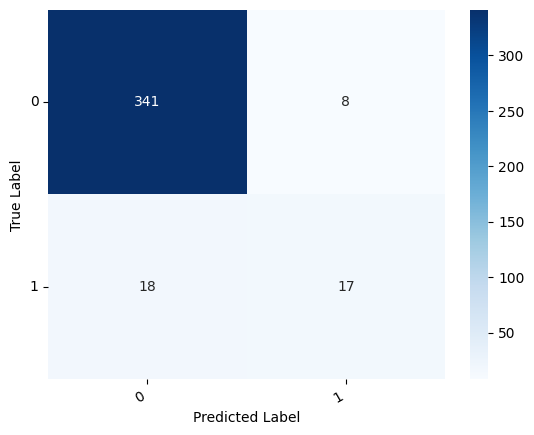

In [60]:
predictions_lstm_1 = lstm_model.predict(x_test_padded1)
predicted_labels_lstm_1 = (predictions_lstm_1 > 0.5).astype(int)
cm_lstm_1 = confusion_matrix(y_test1,predicted_labels_lstm_1)
show_confusion_matrix(cm_lstm_1)

####SVMSMOTE

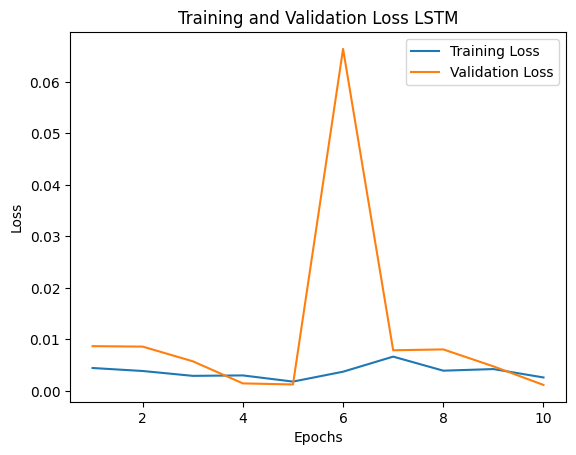

In [61]:
import matplotlib.pyplot as plt
train_loss_lstm = history_lstm_svm.history['loss']
val_loss_lstm = history_lstm_svm.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_lstm) + 1), train_loss_lstm, label='Training Loss')
plt.plot(range(1, len(val_loss_lstm) + 1), val_loss_lstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss LSTM')
plt.legend()
plt.show()

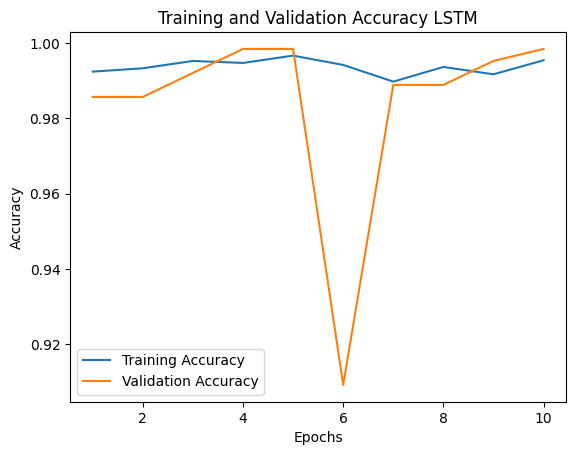

In [62]:
import matplotlib.pyplot as plt
accuracy_lstm = history_lstm_svm.history['accuracy']
val_accuracy_lstm = history_lstm_svm.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_lstm) + 1), accuracy_lstm, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_lstm) + 1), val_accuracy_lstm, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy LSTM')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


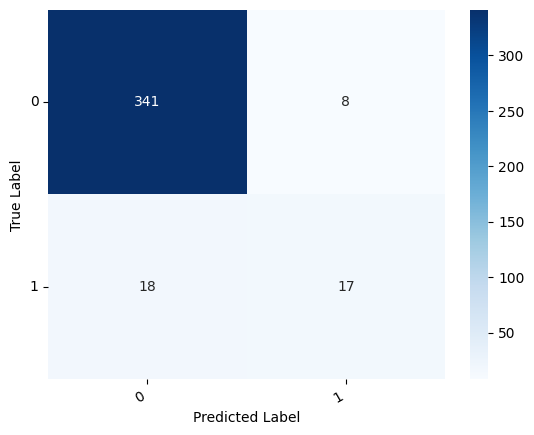

In [63]:
predictions_lstm_1 = lstm_model.predict(x_test_padded1)
predicted_labels_lstm_1 = (predictions_lstm_1 > 0.5).astype(int)
cm_lstm_1 = confusion_matrix(y_test1,predicted_labels_lstm_1)
show_confusion_matrix(cm_lstm_1)